In [49]:
import os
os.chdir('/Users/jjaniak/Documents/studia/projekt/gradient')

import geopandas as gpd
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import shap
import numpy as np

from shapely.wkt import loads

from esda.moran import Moran_Local
import libpysal

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from src.embedders.osm_data_embedder import OSMDataEmbedder
from srai.regionalizers import geocode_to_region_gdf
from srai.embedders import CountEmbedder
from srai.regionalizers import H3Regionalizer
from srai.loaders.osm_loaders.filters import OsmTagsFilter

from IPython.display import display

pd.set_option("display.max_columns", None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [50]:
city_name = "Pozna\u0144"
nominatim_city_name = "Pozna\u0144, Poland"
year = 2022

In [51]:
# Parameters
city_name = "Warszawa"
nominatim_city_name = "Warszawa, Poland"
year = 2022


## Functions

In [52]:
query: OsmTagsFilter = {"highway": True, "railway": True, "route": True}


def create_hex_gds(h3_resolution, city_name=city_name):
    data_embedder = OSMDataEmbedder(
        area=geocode_to_region_gdf(nominatim_city_name),
        embedder=CountEmbedder(),
        regionalizer=H3Regionalizer(resolution=h3_resolution),
        query=query,
    )

    filename = f"data/baseline-datasets/in/{city_name}-hex-res-{h3_resolution}-and-features-gdf.shp"

    if not os.path.exists(filename):
        hex_and_features_gdf = data_embedder.make_embeddings()  # type: ignore
        hex_and_features_gdf.to_file(
            filename,
            index=True,
        )
    else:
        hex_and_features_gdf = gpd.read_file(filename)
        hex_and_features_gdf.set_index("region_id", inplace=True)

    return hex_and_features_gdf


def get_accidents_gdf(h3_resolution, city_name=city_name, year=year):
    filename = f"data/accidents_in_hex/{city_name}_accidents_{year}_res{h3_resolution}.csv"
    if not os.path.exists(filename):
        raise FileNotFoundError(f"The file {filename} does not exist.")
    else:
        accidents_df = pd.read_csv(filename)
        accidents_df['geometry'] = accidents_df['geometry'].apply(loads)
        accidents_gdf = gpd.GeoDataFrame(accidents_df, geometry='geometry', crs="EPSG:4326")
        return accidents_gdf
    
def merge_gdf(accidents_gdf, hex_and_features_gdf):
    merged_gdf = gpd.sjoin(left_df=accidents_gdf, right_df=hex_and_features_gdf, how='inner', op='intersects')
    merged_gdf = merged_gdf.drop(columns='index_right')
    merged_gdf.rename(columns={'count': 'num_accidents'}, inplace=True)
    merged_gdf['num_accidents'] = merged_gdf['num_accidents'].astype(int)

    return merged_gdf

In [53]:
def local_moran(df, column):
    w = libpysal.weights.Queen.from_dataframe(df)
    y = df[column].values
    moran_loc = Moran_Local(y, w)
    return moran_loc.Is, moran_loc.p_sim, moran_loc.q

In [54]:
def correlation_analysis(merged_gdf):
    all_features = merged_gdf.drop(columns=['geometry', 'region_id', 'num_accidents', 'binary_accidents']).columns.to_list()
    
    correlation_matrix = merged_gdf[all_features + ['binary_accidents']].corr()
    correlation_values = correlation_matrix['binary_accidents']

    correlation_metrics = correlation_values.drop('binary_accidents').describe()

    # Calculate the interquartile range (IQR)
    Q1 = correlation_values.drop('binary_accidents').quantile(0.25)
    Q3 = correlation_values.drop('binary_accidents').quantile(0.75)
    IQR = Q3 - Q1

    # Filter features based on IQR
    best_features = correlation_values[(correlation_values < (Q1 - 0.5 * IQR)) | (correlation_values > (Q3 + 0.5 * IQR))].index.to_list()

    best_features.remove('binary_accidents')
    correlation_matrix_best_features = merged_gdf[best_features + ['binary_accidents']].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix_best_features, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap (best features)')
    plt.show()

    return best_features, correlation_metrics

In [55]:
def shap_analysis(h3_resolution, merged_gdf, selected_features, city_name=city_name, save_force_plot=False):
    y = merged_gdf['binary_accidents']
    X = merged_gdf[selected_features]

    X_train, X_test, y_train, _ = train_test_split(X, y, test_size=0.3, random_state=42)

    linear_lr = LogisticRegression(max_iter=1000)
    linear_lr.fit(X_train, y_train)

    #Przygotowanie przybliżonej próbki tła za pomocą metody k-means.
    background_summary = shap.kmeans(X_train, 10)

    explainer = shap.KernelExplainer(linear_lr.predict_proba, background_summary)

    #Obliczenie SHAP wartości dla danych testowych (X_test), co pozwala na zrozumienie, jak każda zmienna przyczynia się do przewidywanej wartości.
    shap_values = explainer.shap_values(X_test)

    shap.summary_plot(shap_values, X_test)

    if save_force_plot:
        shap.initjs()
        p = shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)
        shap.save_html(f'{city_name}_res_{h3_resolution}_force_plot_best_features.html', p)

## Analysis

Analysis for Resolution = 8
Summary Statistics of Numerical Columns (Sorted by Mean):


,railway_12,route_pist,route_bicy,highway_em,railway_10,railway_20,railway_sp,railway_19,railway_fu,railway_de,highway__2,railway_tr,railway__4,railway_ju,railway_pi,railway_tu,railway_hu,route_hist,highway_pl,railway__1,railway_se,highway_17,railway_wo,railway_ya,railway_wa,railway_ve,railway_lo,railway_en,railway_ra,route_ferr,highway_pa,highway_br,route_inli,railway_di,highway__3,railway_pr,highway_ra,railway__8,railway_ha,railway_11,highway_mo,highway_sp,railway_st,highway__1,highway_13,railway__2,highway_mi,railway__9,highway_10,railway_pl,railway__5,highway_12,railway_cr,railway_13,railway_co,railway_14,binary_accidents,railway__6,railway_su,highway_el,highway__8,highway_16,railway_mi,highway_15,highway_un,railway_ab,railway_bu,railway_18,highway__6,railway__3,highway_tu,highway_pe,num_accidents,railway_le,railway_17,highway_co,highway__7,railway_16,highway_gi,highway_pr,railway_15,railway_sw,railway_si,highway_14,highway__5,railway__7,highway_bu,highway_li,highway_tr,highway_se,highway_te,highway_cy,highway_st,highway__4,highway_re,highway_11,highway_cr,highway__9,highway_fo
count,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.00000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000
mean,0.001235,0.001235,0.001235,0.001235,0.001235,0.001235,0.001235,0.001235,0.002469,0.002469,0.002469,0.002469,0.003175,0.003704,0.003704,0.003704,0.003704,0.003704,0.004938,0.004938,0.006173,0.006173,0.006173,0.006173,0.007407,0.008642,0.009877,0.009877,0.009877,0.014286,0.015344,0.017108,0.017284,0.019400,0.021869,0.023457,0.024868,0.041975,0.048677,0.055556,0.058377,0.061552,0.065432,0.070370,0.078660,0.094709,0.098236,0.162963,0.210229,0.211287,0.217813,0.226808,0.267901,0.269312,0.307407,0.371605,0.383069,0.389771,0.434568,0.470370,0.501940,0.515873,0.521693,0.589242,0.650441,0.670194,0.733510,0.762963,0.799824,0.834921,0.845326,0.902116,0.919753,0.928748,1.340741,1.507407,1.569665,1.585185,1.981305,2.085538,2.233333,2.932099,3.114462,3.785891,4.387302,4.509700,4.80776,4.929277,5.185891,6.254850,8.108818,8.549912,9.415344,16.042857,17.366138,22.250970,31.340564,76.757848,144.485362
std,0.035118,0.035118,0.035118,0.035118,0.035118,0.035118,0.035118,0.035118,0.049633,0.070236,0.049633,0.049633,0.056259,0.060751,0.078487,0.078487,0.078487,0.105353,0.085932,0.070105,0.078331,0.078331,0.105238,0.078331,0.121501,0.135820,0.248278,0.140211,0.098898,0.128661,0.170947,0.257312,0.457837,0.275368,0.162278,0.507464,0.371762,1.194006,0.226396,0.290831,0.282267,0.379748,0.261859,0.798981,0.456412,0.493411,0.343855,1.148632,0.983136,0.775902,1.237105,0.954636,1.366384,1.003061,2.426524,1.866417,0.486178,1.800149,2.532248,1.796516,2.897724,2.752765,3.469059,2.200416,2.149024,2.592418,3.089319,2.033995,3.530723,3.555112,1.762156,3.351588,1.693715,5.428689,4.936315,9.438002,4.289777,5.079651,5.979798,5.583907,9.681744,12.196883,12.667510,6.382499,5.613586,16.489732,4.83323,9.886288,7.597872

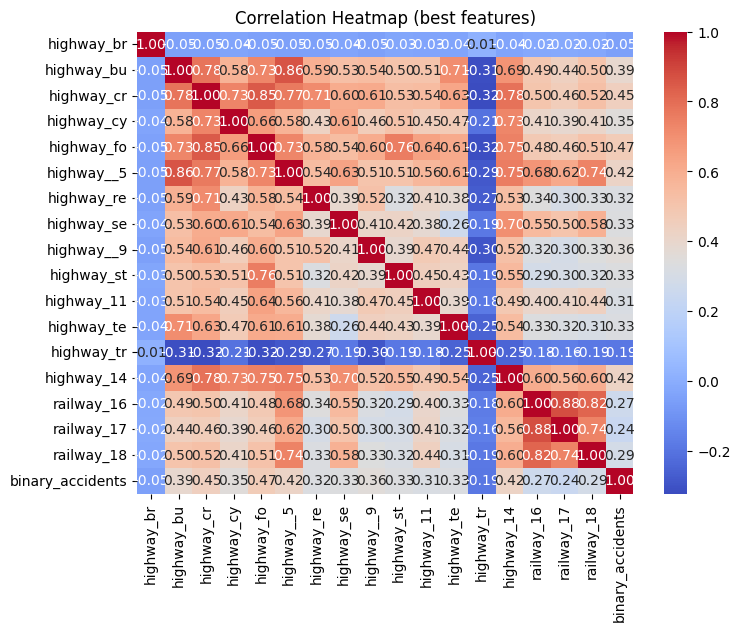

100%|██████████| 1701/1701 [05:09<00:00,  5.50it/s]


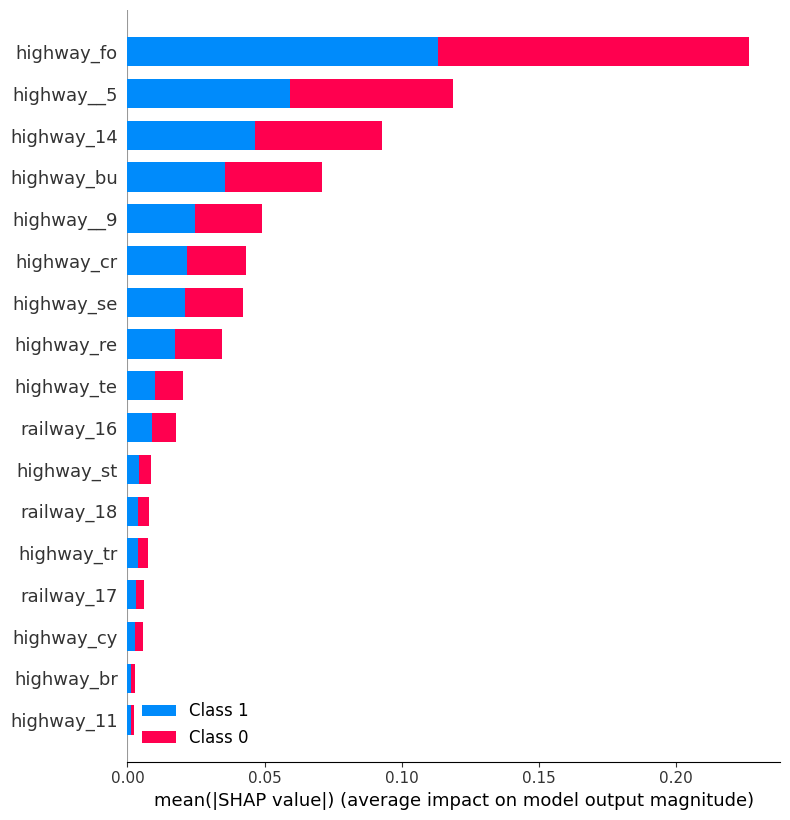

Analysis for Resolution = 9
Summary Statistics of Numerical Columns (Sorted by Mean):


,railway_12,railway_sp,route_bicy,railway_19,railway_20,highway_em,railway_de,route_pist,railway_10,railway_fu,railway_tr,highway__2,railway_pi,railway_tu,railway_hu,railway_ju,railway__1,route_hist,railway__4,highway_pl,highway_17,railway_se,railway_ya,railway_wa,railway_wo,railway_lo,railway_ve,railway_ra,railway_en,highway_pa,highway__3,railway_di,railway_pr,route_ferr,route_inli,highway_ra,highway_br,railway__8,railway_ha,railway_11,highway_mo,highway_sp,railway_st,highway__1,highway_13,railway__2,highway_mi,railway__9,highway_10,highway_12,railway_cr,railway_13,railway_pl,railway__5,railway_14,railway_co,highway_el,railway_mi,highway__8,highway_16,railway__6,binary_accidents,railway_bu,railway_18,railway_su,highway_tu,highway_un,highway_15,num_accidents,railway_le,highway__6,railway_ab,highway_pe,railway__3,railway_17,railway_16,highway_co,highway_gi,highway__7,highway_pr,railway_sw,railway_si,railway_15,highway_14,highway__5,highway_bu,highway_li,highway_tr,railway__7,highway_se,highway_st,highway_te,highway_cy,highway__4,highway_11,highway_re,highway_cr,highway__9,highway_fo
count,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.00000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000
mean,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000366,0.000366,0.000366,0.000366,0.000366,0.000366,0.000550,0.000550,0.000550,0.000550,0.000733,0.000733,0.000733,0.000733,0.000916,0.000916,0.000916,0.001099,0.001282,0.001466,0.001466,0.001466,0.001649,0.002382,0.003271,0.003429,0.003481,0.003743,0.004030,0.004475,0.005496,0.006229,0.007302,0.008244,0.008663,0.009160,0.00971,0.011175,0.011699,0.014107,0.014525,0.024183,0.031459,0.038630,0.039991,0.040017,0.043602,0.043681,0.055144,0.062237,0.070638,0.077233,0.085713,0.094428,0.099846,0.101102,0.108953,0.113219,0.117067,0.126436,0.128033,0.129472,0.136460,0.138187,0.142689,0.151378,0.162449,0.173205,0.198958,0.235233,0.241645,0.302075,0.352247,0.397210,0.435264,0.462326,0.470282,0.562119,0.707739,0.715198,0.878903,1.047005,1.060693,1.133764,1.420634,1.459447,1.500222,2.996205,3.306027,3.414955,4.661310,12.796619,23.955089
std,0.013534,0.013534,0.013534,0.013534,0.013534,0.013534,0.027068,0.019138,0.019138,0.019138,0.019138,0.019138,0.023438,0.023438,0.030261,0.023438,0.027061,0.038277,0.027061,0.027061,0.030252,0.030252,0.030252,0.046875,0.044874,0.085593,0.054122,0.038256,0.052397,0.055757,0.057104,0.094409,0.183071,0.063993,0.154275,0.132247,0.111481,0.313890,0.087265,0.092427,0.096545,0.142952,0.09806,0.292916,0.148957,0.164618,0.121166,0.373835,0.318100,0.335589,0.445904,0.341803,0.328510,0.518151,0.625917,0.909050,0.561594,0.832952,0.886106,0.855617,0.698918,0.301467,0.785045,0.564612,0.951935,0.496327,0.732516,0.763771,0.471067,1.338105,1.183535,0.862610,1.009517,1.258989,1.375424,1.413656,3.343151,1.682407,1.40848

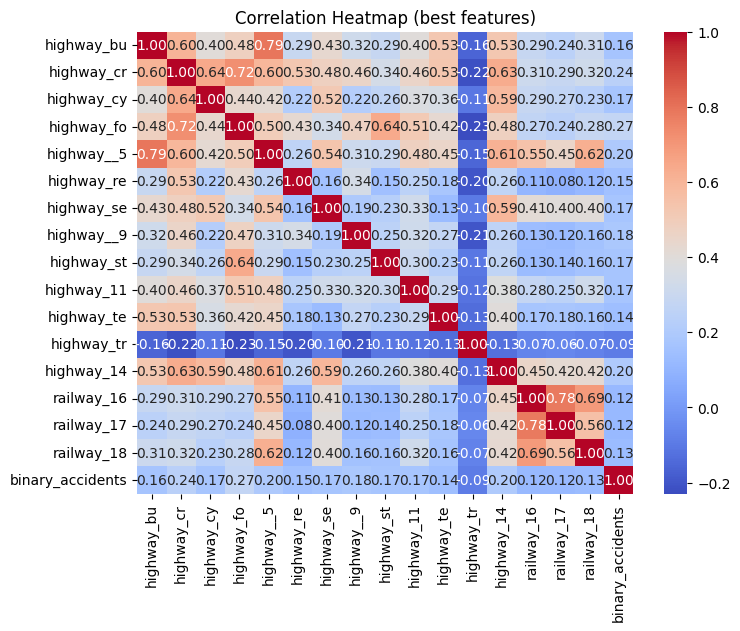

100%|██████████| 11463/11463 [4:13:21<00:00,  1.33s/it]      


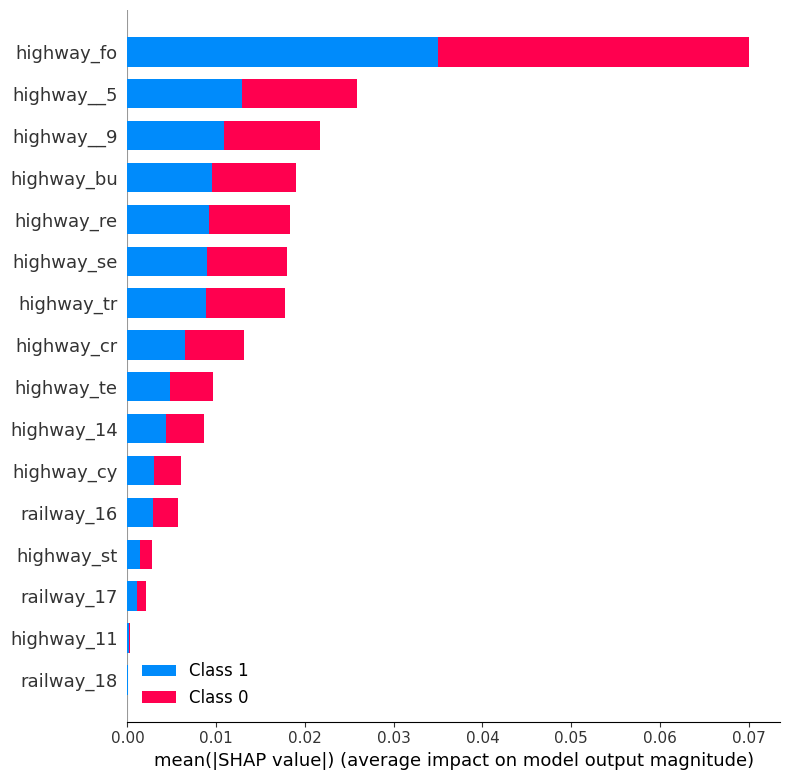

Analysis for Resolution = 10
Summary Statistics of Numerical Columns (Sorted by Mean):


,railway_sp,railway_12,railway_20,highway_em,railway_de,railway_fu,railway_tr,railway_19,route_bicy,highway__2,railway_pi,railway_ju,route_pist,railway_hu,highway_17,railway_10,railway_se,railway_tu,railway__1,railway_ya,railway__4,route_hist,railway_ra,railway_lo,railway_ve,highway_pl,railway_wa,highway_pa,railway_wo,railway_en,highway__3,railway_pr,railway_di,route_ferr,railway__8,route_inli,railway_ha,highway_ra,highway_mo,highway_sp,railway_11,railway_st,highway_13,highway__1,railway__2,highway_br,highway_mi,railway__9,highway_10,railway_cr,railway_13,highway_12,railway_14,highway_el,railway_pl,railway_mi,railway__5,railway_bu,railway_18,railway_co,highway__8,binary_accidents,highway_tu,num_accidents,railway_le,highway_16,railway_17,highway_un,railway__6,highway__6,railway_16,highway_pe,highway_15,railway_su,railway_ab,highway_gi,railway__3,highway_co,railway_sw,railway_si,highway_14,highway_pr,highway__7,highway_bu,railway_15,highway__5,highway_li,highway_st,highway_se,highway_tr,highway_cy,railway__7,highway_te,highway_11,highway__4,highway_cr,highway_re,highway__9,highway_fo
count,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000,263515.000000
mean,0.000027,0.000027,0.000027,0.000027,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000080,0.000080,0.000080,0.000080,0.000133,0.000133,0.000133,0.000133,0.000133,0.000133,0.000148,0.000159,0.000213,0.000213,0.000213,0.000239,0.000239,0.000345,0.000345,0.000425,0.000474,0.000505,0.000759,0.000839,0.000903,0.000983,0.001063,0.001256,0.001271,0.001328,0.001408,0.001408,0.001700,0.002019,0.002045,0.002072,0.002137,0.003506,0.004569,0.005814,0.005814,0.006478,0.007996,0.010254,0.010880,0.011237,0.011620,0.015806,0.016417,0.016568,0.016815,0.017908,0.018378,0.019821,0.020067,0.022219,0.028848,0.029771,0.029793,0.030552,0.034108,0.035493,0.035744,0.036074,0.040176,0.043891,0.044180,0.045075,0.063116,0.067074,0.081506,0.090488,0.097797,0.103907,0.117838,0.124065,0.188866,0.214124,0.241546,0.258357,0.301330,0.302806,0.308070,0.479764,0.671172,0.676626,0.815563,2.396133,4.459545
std,0.005154,0.005154,0.005154,0.005154,0.010308,0.007289,0.007289,0.007289,0.007289,0.007289,0.008927,0.008927,0.008927,0.011524,0.011524,0.011524,0.011524,0.013636,0.011524,0.011524,0.012165,0.016298,0.014576,0.024174,0.020615,0.015460,0.019960,0.019958,0.021248,0.024171,0.021775,0.053311,0.038067,0.029851,0.103334,0.057615,0.032580,0.058460,0.035632,0.049953,0.037496,0.037496,0.047766,0.100978,0.053771,0.059179,0.046745,0.129318,0.113297,0.152111,0.119278,0.124155,0.159907,0.158694,0.152643,0.207845,0.237105,0.224280,0.182212,0.319180,0.278239,0.132617,0.154498,0.154737,0.351069,0.297017,0.435040,0.2715

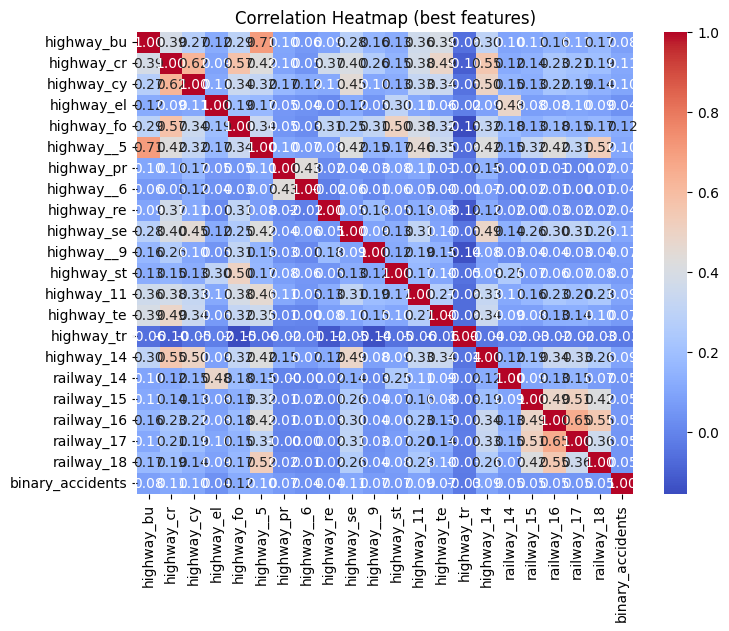

100%|██████████| 79055/79055 [10:10:57<00:00,  2.16it/s]     


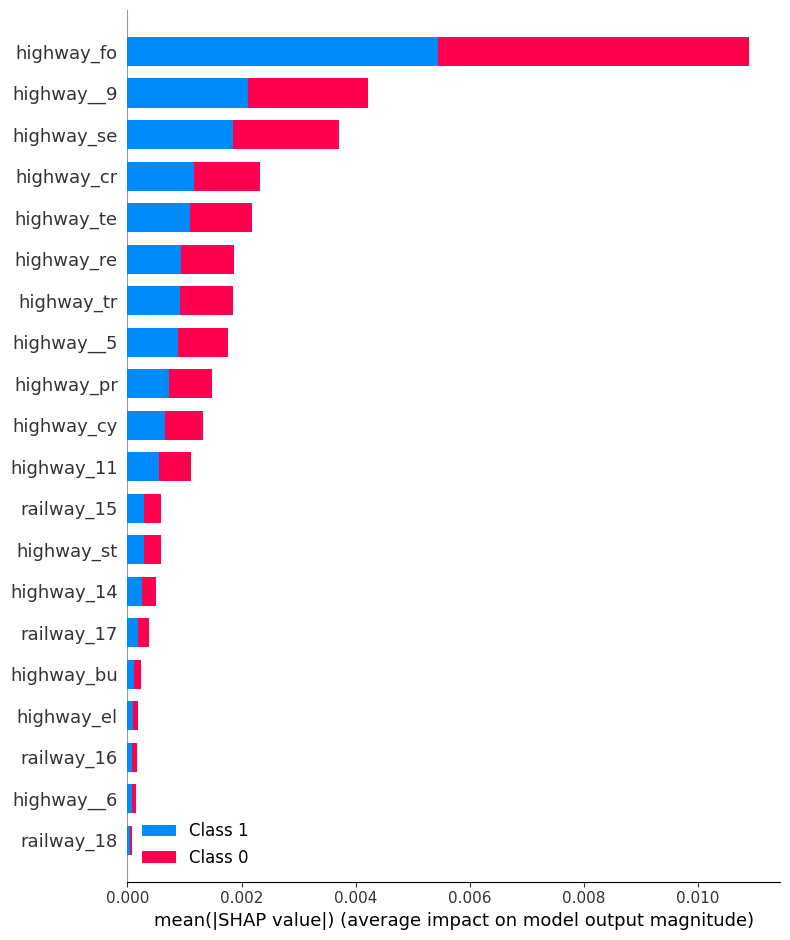

In [56]:
# Set resolutions
resolutions = [8, 9, 10]

# Initialize dataframe and dictionaries to store results
distribution_results = pd.DataFrame(columns=['Resolution', 'Num_Hexes', 'Accidents_Mean', 'Accidents_Std','Binary_Accidents_Mean', 'Binary_Accidents_Std'])
moran_i_results = pd.DataFrame(columns=['Resolution', 'Mean', 'Std', 'Min','Max'])
df_correlation_metrics = pd.DataFrame()

best_features_based_on_correlation = {}
local_moran_results = {} 

# Loop through resolutions
for resolution in resolutions:
    
    print(f"Analysis for Resolution = {resolution}")
    
    # Create hex dataframes
    hex_and_features_gdf = create_hex_gds(h3_resolution=resolution, city_name=city_name)
    accidents_gdf = get_accidents_gdf(h3_resolution=resolution, city_name=city_name, year=year)
    merged_gdf = merge_gdf(accidents_gdf, hex_and_features_gdf)
    
    # Convert accidents count to binary classification
    merged_gdf['binary_accidents'] = 0  # Initialize with 0
    merged_gdf.loc[merged_gdf["num_accidents"] > 0, "binary_accidents"] = 1.0

    new_row = {
        'Resolution': resolution,
        'Num_Hexes': len(merged_gdf),
        'Accidents_Mean': merged_gdf['num_accidents'].mean(),
        'Accidents_Std': merged_gdf['num_accidents'].std(),
        'Binary_Accidents_Mean': merged_gdf['binary_accidents'].mean(),
        'Binary_Accidents_Std': merged_gdf['binary_accidents'].std()
    }
    result_df = pd.DataFrame([new_row], columns=distribution_results.columns)
    distribution_results = pd.concat([distribution_results, result_df], ignore_index=True)
    
    # Summary statistics of numerical columns
    summary_statistics = merged_gdf.describe()
    mean_row = summary_statistics.loc['mean']
    sorted_columns = mean_row.sort_values().index
    summary_statistics_sorted = summary_statistics[sorted_columns]
    print("Summary Statistics of Numerical Columns (Sorted by Mean):")
    display(summary_statistics_sorted)
    
    # Correlation
    best_features, correlation_metrics = correlation_analysis(merged_gdf)
    df_correlation_metrics = pd.concat([df_correlation_metrics, correlation_metrics], axis=1)
    best_features_based_on_correlation[resolution] = best_features
    
    shap_analysis(h3_resolution=resolution, merged_gdf=merged_gdf, selected_features=best_features)
    
    # Calculate Local Moran's I
    moran_i, p_sim, q = local_moran(merged_gdf, column='num_accidents')
    local_moran_results[resolution] = {'moran_i': moran_i, 'p_sim': p_sim, 'q': q}
    new_row = {
        'Resolution': resolution,
        'Mean':  np.mean(moran_i),
        'Std': np.std(moran_i),
        'Min': np.min(moran_i),
        'Max': np.min(moran_i),
    }
    result_df = pd.DataFrame([new_row], columns=distribution_results.columns)
    distribution_results = pd.concat([distribution_results, result_df], ignore_index=True)

Średnia wartość Shapley'a (SHAP) maleje wraz ze wzrostem rozdzielczości. Dla resolution 10 jej wartość dla istotnych na podstawie wcześniejszej analizy korelacji cech, jest poniżej 0.01 (co jest większe w porównaniu do reszty miast), więc wybrane cechy mają niewielki wpływ na przewidywania modelu. Natomiast dla najmniejszego resolution równego 8 średnia wartość shap jest ponizej 0.2 (co równiez jest największą wartością górnej granicy dla wszystkich analizowanych miast). 

Cechy, które mozna pominąć na podstawie statystyk (ich liczba jest odwrotnie proporcjonalna do wartości resolution, poniej została wypisana ich suma):		
- railway_10	
- highway_17
- railway_ow	
- railway__5	
- railway_12
- highway_em
- railway_de
- railway_fu
- railway_tr
- railway_19
- route_bicy
- highway__2
- railway_pi
- route_pist
- railway_tu
- railway_se
- railway__1
- railway_20 
- railway_sp
- highway__2
- railway__4
- railway_ju
- railway__1
- highway_pl

Wszystkie z nich wystąpiły tylko raz w heksagonach dla rozdzielczości 8, 9, 10. Ich srednia wartość występowania na hexagon jest bliska 0. Żadna z nich nie wykazuje wysokiej korelacji względem binarnej klasyfikacji wypadków.

In [57]:
df_correlation_metrics.columns = [f'resolution={resolution}' for resolution in resolutions]
print("Correlation Metrics of Binary Accidents with All Features:")
display(df_correlation_metrics)

Correlation Metrics of Binary Accidents with All Features:


,resolution=8,resolution=9,resolution=10
count,97.000000,97.000000,97.000000
mean,0.100754,0.041769,0.018905
std,0.127383,0.065081,0.031140
min,-0.189427,-0.093156,-0.031720
25%,0.016945,0.000543,-0.000934
50%,0.055377,0.014303,0.004379
75%,0.152060,0.068756,0.023557
max,0.466377,0.274515,0.123701


Istnieje pewne pozytywne skorelowanie między wypadkami a cechami, zwłaszcza dla rozdzielczości 8, gdzie średnia korelacja wynosi 0.1. Korelacje te są stosunkowo niskie, co sugeruje, że analizowane cechy nie wykazują silnej zależności od występowania wypadków na danym obszarze w zależności od rozdzielczości siatki H3. 

### Rozkład wypadków

In [43]:
print("Distribution of Accidents in Hexes:")
display(distribution_results)

Distribution of Accidents in Hexes:


,Resolution,Num_Hexes,Accidents_Mean,Accidents_Std,Binary_Accidents_Mean,Binary_Accidents_Std
0,8,5670,0.919753,1.693715,0.383069,0.486178
1,9,38209,0.136460,0.471067,0.101102,0.301467
2,10,263515,0.019821,0.154737,0.017908,0.132617


**Wnioski:**
- W miarę wzrostu rozdzielczości (malejące rozmiary heksagonów), średnia liczba wypadków na heksagon maleje, ale rozkład staje się bardziej skoncentrowany.
- Analiza binarna wypadków (czy wypadł w ogóle czy nie) pokazuje, że dla najniższej rozdzielczości (8) obszary są bardziej zróżnicowane, podczas gdy dla wyższych rozdzielczości (9 i 10) wypadki są bardziej skoncentrowane w niektórych obszarach.

### Istotne cechy

In [39]:
print("Best Features Based on Correlation:\n")
for resolution, best_features in best_features_based_on_correlation.items():
    print(f"\nResolution {resolution}:")
    for feature in best_features:
        print(f"{feature}")

Best Features Based on Correlation:


Resolution 8:
highway_br
highway_bu
highway_cr
highway_cy
highway_fo
highway__5
highway_re
highway_se
highway__9
highway_st
highway_11
highway_te
highway_tr
highway_14
railway_16
railway_17
railway_18

Resolution 9:
highway_bu
highway_cr
highway_cy
highway_fo
highway__5
highway_re
highway_se
highway__9
highway_st
highway_11
highway_te
highway_tr
highway_14
railway_16
railway_17
railway_18

Resolution 10:
highway_bu
highway_cr
highway_cy
highway_el
highway_fo
highway__5
highway_pr
highway__6
highway_re
highway_se
highway__9
highway_st
highway_11
highway_te
highway_tr
highway_14
railway_14
railway_15
railway_16
railway_17
railway_18


In [28]:

features_resolution_8 = best_features_based_on_correlation[8]
features_resolution_9 = best_features_based_on_correlation[9]
features_resolution_10 = best_features_based_on_correlation[10]

# Find common features
common_features = set(features_resolution_8) & set(features_resolution_9) & set(features_resolution_10)

print("Common Features Across All Resolutions:")
for feature in common_features:
    print(feature)


Common Features Across All Resolutions:
highway_fo
highway_re
highway__9
railway_16
highway__5
highway_bu
highway_11
railway_18
highway_cy
highway_st
highway_se
highway_cr
highway_14
highway_te
highway_tr
railway_17


### Moran's I

In [47]:
print("Local Moran's I Results:")
for resolution, results in local_moran_results.items():
    print(f"Resolution {resolution}: Moran's I = {results['moran_i']}, p_sim = {results['p_sim']}, q = {results['q']}")

Local Moran's I Results:
Resolution 8: Moran's I = [-0.197291    0.24813422  0.15462003 ...  0.15462003  0.19514284
 -0.0181526 ], p_sim = [0.008 0.001 0.009 ... 0.014 0.001 0.001], q = [4 3 3 ... 3 3 4]
Resolution 9: Moran's I = [0.08391626 0.08391626 0.08391626 ... 0.08391626 0.08391626 0.08391626], p_sim = [0.001 0.001 0.001 ... 0.111 0.001 0.001], q = [3 3 3 ... 3 3 3]
Resolution 10: Moran's I = [-0.10431331  0.0164074  10.27570978 ...  0.0164074   0.0164074
  0.0164074 ], p_sim = [0.002 0.415 0.001 ... 0.341 0.431 0.479], q = [2 3 1 ... 3 3 3]


In [48]:
res = {}
for resolution, results in local_moran_results.items():
    res[resolution] = []
    for key, value in results.items():
        res[resolution].extend([np.mean(value), np.std(value), np.min(value), np.max(value)])

local_moran_metrics = list(local_moran_results.values())[0].keys()
id_names = [f'{key}_{stat}' for key in local_moran_metrics for stat in ['mean', 'std', 'min', 'max']]
        
df = pd.DataFrame(res, index=id_names)
df.columns = [f'resolution={resolution}' for resolution in df.columns]
display(df)

,resolution=8,resolution=9,resolution=10
moran_i_mean,0.564889,0.255955,0.178096
moran_i_std,2.382028,1.559899,2.109681
moran_i_min,-0.827279,-1.261290,-0.949358
moran_i_max,41.089494,56.440299,176.789183
p_sim_mean,0.054964,0.085322,0.364146
p_sim_std,0.113699,0.167535,0.128073
p_sim_min,0.001000,0.001000,0.001000
p_sim_max,0.479000,0.500000,0.500000
q_mean,2.550970,2.572431,2.877396
q_std,1.006747,0.668549,0.378666


#### Wnioski

**moran_i** <br>
Dla rozdzielczości 8 (największe hexy) obserwujemy silniejszy lokalny wzorzec korelacji. Oznacza to, że obszary o podobnych wartościach są bardziej skupione przestrzennie dla większych heksagonów. Odchylenie standardowe jest największe równiez dla rozdzielczości 8, co wskazuje na większą zmienność lokalnej korelacji przestrzennej w obszarach o większych heksagonach.

**p-wartość** <br>
Wartości p_sim są stosunkowo niskie dla wszystkich rozdzielczości, co wskazuje na istotność statystyczną lokalnego wzorca przestrzennej korelacji. Największe wartości p_sim (bliskie 0.5) mogą pochodzić z obszarów o losowym rozkładzie, gdzie brak jest wyraźnych lokalnych wzorców. Wartości minimalne i wartość średnia sugerują, że dla większości obszarów lokalne wzorce korelacji są istotne.

**Q** <br>
Średnie wartości Q dla wszystkich rozdzielczości wskazują na to, że istnieją klastry obszarów o podobnych wartościach w sąsiedztwie. Maksymalna wartość Q dla rozdzielczości 8 i 9 wynosi 4, co sugeruje, że istnieją obszary otoczone przez obszary o podobnych wartościach.